# Part 1


Creating RawArray with float64 data, n_channels=8, n_times=60871
    Range : 0 ... 60870 =      0.000 ...   243.480 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


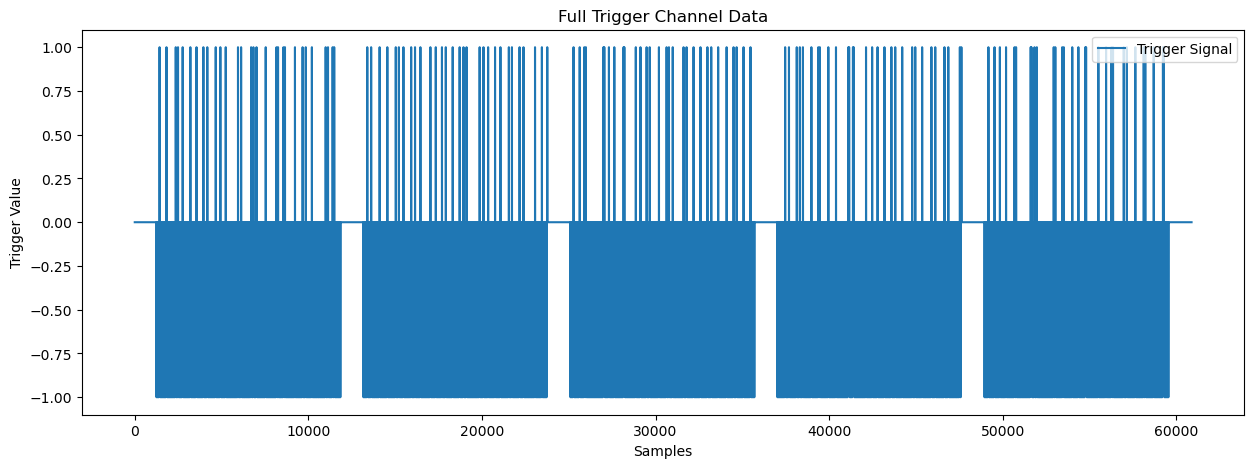

C:\Users\Tomar\AppData\Local\Temp\ipykernel_30396\3365103337.py:66: RuntimeWarning: event 0 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_id)


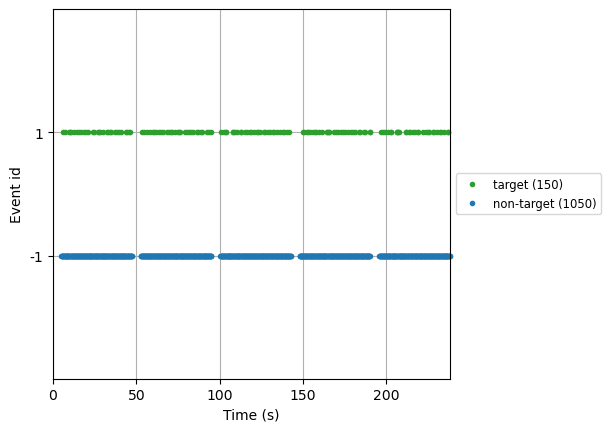

Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 226 original time points ...
0 bad epochs dropped
Not setting metadata
1200 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1200 events and 276 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Re

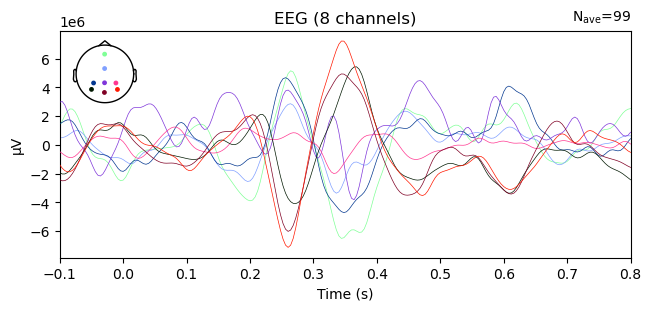

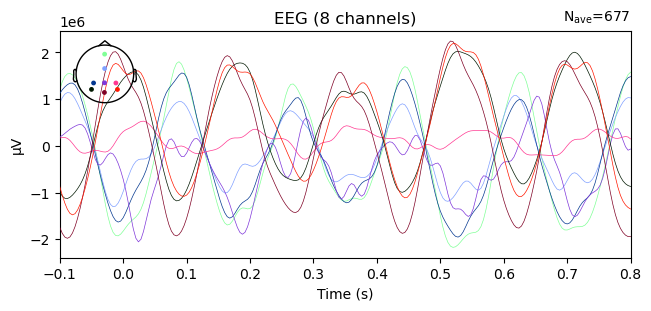

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\Tomar\AppData\Local\Temp\ipykernel_30396\3365103337.py:82: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd_fig = cleaned_epochs['target'].plot_psd(show=True)
c:\Users\Tomar\miniconda3\envs\py311\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


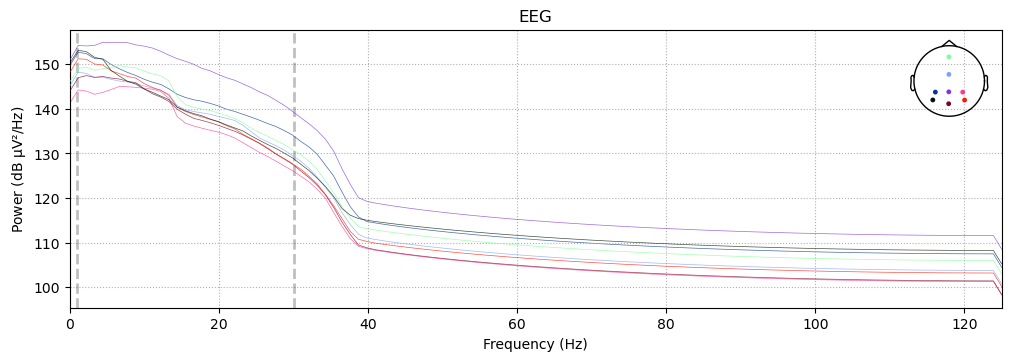

In [1]:
import numpy as np
import scipy.io as sio
import mne
import matplotlib.pyplot as plt
from mne import Epochs, pick_types

# Define functions for loading data, preprocessing, and artifact rejection

def load_data(file_path):
    mat_data = sio.loadmat(file_path)
    fs = mat_data['fs'][0, 0]  # Sampling frequency
    y = mat_data['y']  # EEG data
    trig = mat_data['trig'][:, 0]  # Ensure trig is 1D
    return y, trig, fs

def preprocess_eeg_data(y, trig, fs):
    ch_names = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'Oz', 'PO8']
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(y.T, info)
    # set the average reference
    raw.set_eeg_reference('average', projection=False)
    raw.filter(1., 30., fir_design='firwin')
    return raw, trig

def plot_full_trigger_data(trig):
    plt.figure(figsize=(15, 5))
    plt.plot(trig, label='Trigger Signal')
    plt.title('Full Trigger Channel Data')
    plt.xlabel('Samples')
    plt.ylabel('Trigger Value')
    plt.legend()
    plt.show()

def reject_parameter(raw, events):
    picks = pick_types(raw.info, meg=True, eeg=True, stim=False)
    # Define event IDs
    event_id = {'non-target': -1, 'target': 1}
    dummy_epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=1.0,
                     picks=picks, baseline=(None, 0), preload=True,
                     reject=None)

    from autoreject import get_rejection_threshold  # noqa
    reject = get_rejection_threshold(dummy_epochs)
    return reject


# Load and preprocess the data
file_path = './p300/S1.mat'
y, trig, fs = load_data(file_path)
raw, trig = preprocess_eeg_data(y, trig, fs)

# Manually create events array from the cleaned triggers
event_times = np.where(np.diff(trig) != 0)[0] + 1  # Find changes in trigger values
event_values = trig[event_times]  # Get the trigger values at these times
events = np.column_stack((event_times, np.zeros_like(event_times), event_values))

# Plot full trigger data to understand its behavior
plot_full_trigger_data(trig)

# Define event IDs
event_id = {'non-target': -1, 'target': 1}

# Plot full trigger events for targets and non-targets
fig = mne.viz.plot_events(events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_id)

# Create epochs for ERP analysis
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=0.8, baseline=(None, 0), preload=True)

# get reject parameter
reject = reject_parameter(raw, events)
cleaned_epochs = epochs.drop_bad(reject)

evoked_trg = cleaned_epochs['target'].average()
evoked_nontrg = cleaned_epochs['non-target'].average()

evoked_trg.plot()
evoked_nontrg.plot()

# Plot the Power Spectral Density components
psd_fig = cleaned_epochs['target'].plot_psd(show=True)
plt.show()


# Part 2


In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def calculate_psd(data, sfreq):
    """Calculate power spectral density using numpy's FFT."""
    fft_data = np.fft.rfft(data, axis=2)
    psd = np.abs(fft_data)**2
    return psd.mean(axis=2)  # Average PSD across frequencies

def prepare_data(epochs):
    """Prepare labels and PSD features for machine learning."""
    labels = epochs.events[:, -1]
    encoder = LabelEncoder()
    labels_encoded = encoder.fit_transform(labels)
    
    # Find indices of the minority and majority classes
    minority_indices = np.where(labels_encoded == 1)[0]
    majority_indices = np.where(labels_encoded == 0)[0]
    
    psd_mean = calculate_psd(epochs.get_data(), epochs.info['sfreq'])
    scaler = StandardScaler()
    psd_scaled = scaler.fit_transform(psd_mean)
    
    # Perform the manual oversampling process
    oversampled_minority_indices = np.random.choice(minority_indices, len(majority_indices), replace=True)
    resampled_indices = np.concatenate([majority_indices, oversampled_minority_indices])
    np.random.shuffle(resampled_indices)  # Shuffle indices to mix data
    
    features = psd_scaled[resampled_indices]
    labels = labels_encoded[resampled_indices]
    return train_test_split(features, labels, test_size=0.2, random_state=42)

def train_and_evaluate(X_train, X_test, y_train, y_test):
    """Train RandomForest and evaluate its performance."""
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['non-target', 'target'])
    
    print('Accuracy:', accuracy)
    print('Classification Report:\n', report)

# Main execution
X_train_fft, X_test_fft, y_train_fft, y_test_fft = prepare_data(epochs)
train_and_evaluate(X_train_fft, X_test_fft, y_train_fft, y_test_fft)


C:\Users\Tomar\AppData\Local\Temp\ipykernel_30396\531554932.py:23: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  psd_mean = calculate_psd(epochs.get_data(), epochs.info['sfreq'])


Accuracy: 0.981549815498155
Classification Report:
               precision    recall  f1-score   support

  non-target       1.00      0.97      0.98       148
      target       0.96      1.00      0.98       123

    accuracy                           0.98       271
   macro avg       0.98      0.98      0.98       271
weighted avg       0.98      0.98      0.98       271

